In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import pymorphy2

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import optuna

import lightgbm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1kkiren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1kkiren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1kkiren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\1kkiren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('responses_train.csv', index_col='id')

In [3]:
train.review

id
941     Пытался оплатить услуги мобильной связи мгтс,н...
396     Добрый день. Банк в очередной раз в односторон...
1071    Хочу выразить огромную благодарность и восхище...
1154    Хочу отметить профессионализм в решении вопрос...
491     Полгода назад&amp;amp;nbsp; брал кредит под за...
                              ...                        
1489    Приветствие.&amp;amp;nbsp;&amp;lt;br&amp;gt;Вс...
1432    Хотим поблагодарть сотрудника на Заневском пр-...
397     Обращения в банк&amp;amp;nbsp; сентябрь 2020 г...
540     На бирже 1.5 недели. Речь пойдет о покупке акц...
328     Оформил карточку в банке, понял, что она мне н...
Name: review, Length: 1200, dtype: object

Удалим данные с пропусками

In [4]:
train = train.dropna()


In [5]:
train.head()

,review,is_positive
id,,
941,"Пытался оплатить услуги мобильной связи мгтс,н...",True
396,Добрый день. Банк в очередной раз в односторон...,False
1071,Хочу выразить огромную благодарность и восхище...,True
1154,Хочу отметить профессионализм в решении вопрос...,True
491,Полгода назад&amp;amp;nbsp; брал кредит под за...,False


In [ ]:
train.index

Int64Index([  941,   396,  1071,  1154,   491,  1013,    65,  1103,    60,
              204,
            ...
            37085, 37086, 37087, 37088, 37089, 37090, 37091, 37092, 37093,
            37094],
           dtype='int64', name='id', length=1339)

Сделаем простейший bag of words

In [6]:
vec = CountVectorizer()

In [7]:
# vec = TfidfVectorizer()

# X_train.toarray()[0]


morph = pymorphy2.MorphAnalyzer()

# w_lem_rus = word_tokenize(train['review'][0])

train['Review'] = 0

# for i in range(1200):
#     train['Review'][i] = [morph.normal_forms(word)[0] for word in word_tokenize(review) for review in train['review']]
#     # train['Review'] = ([''])


# w_lem_rus = [morph.normal_forms(word)[0] for word in w_lem_rus]



for id in tqdm(train.index):    
    w_lem_rus = word_tokenize(train['review'][id])
    w_lem_rus = [morph.normal_forms(word)[0] for word in w_lem_rus]
    strn = ''
    for word in w_lem_rus:
        strn += word + ' '

    train['Review'][id] = strn


#     strn = ''
#     for word in w_lem_rus:
#         strn += word + ' '


train



# # w_lem_rus


  0%|          | 0/1199 [00:00<?, ?it/s]C:\Users\1kkiren\AppData\Local\Temp\ipykernel_22472\52745137.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Review'][id] = strn
100%|██████████| 1199/1199 [02:05<00:00,  9.54it/s]


,review,is_positive,Review
id,,,
941,"Пытался оплатить услуги мобильной связи мгтс,н...",True,пытаться оплатить услуга мобильный связь мгтс ...
396,Добрый день. Банк в очередной раз в односторон...,False,добрый день . банк в очередной раз в односторо...
1071,Хочу выразить огромную благодарность и восхище...,True,хотеть выразить огромный благодарность и восхи...
1154,Хочу отметить профессионализм в решении вопрос...,True,хотеть отметить профессионализм в решение вопр...
491,Полгода назад&amp;amp;nbsp; брал кредит под за...,False,полгода назад & amp ; amp ; nbsp ; брать креди...
...,...,...,...
1489,Приветствие.&amp;amp;nbsp;&amp;lt;br&amp;gt;Вс...,True,приветствие. & amp ; amp ; nbsp ; & amp ; lt ;...
1432,Хотим поблагодарть сотрудника на Заневском пр-...,True,хотеть поблагодарть сотрудник на заневский пр-...
397,Обращения в банк&amp;amp;nbsp; сентябрь 2020 г...,False,обращение в банк & amp ; amp ; nbsp ; сентябрь...


In [8]:
X_train = vec.fit_transform(train['review'])
X_train

<1199x20526 sparse matrix of type '<class 'numpy.int64'>'
	with 125825 stored elements in Compressed Sparse Row format>

In [9]:
train['Review']

id
941     пытаться оплатить услуга мобильный связь мгтс ...
396     добрый день . банк в очередной раз в односторо...
1071    хотеть выразить огромный благодарность и восхи...
1154    хотеть отметить профессионализм в решение вопр...
491     полгода назад & amp ; amp ; nbsp ; брать креди...
                              ...                        
1489    приветствие. & amp ; amp ; nbsp ; & amp ; lt ;...
1432    хотеть поблагодарть сотрудник на заневский пр-...
397     обращение в банк & amp ; amp ; nbsp ; сентябрь...
540     на биржа 1.5 неделя . речь пойти о покупка акц...
328     оформить карточка в банк , понять , что она я ...
Name: Review, Length: 1199, dtype: object

Обучим простой классификатор

In [10]:
y_n = []
for i in train.index:
  if train['is_positive'][i] == True:
    y_n.append(1)
  else:
    y_n.append(0)

In [ ]:
y_n

In [14]:
def objective(trial, data = X_train, target = train['is_positive']):
  train_x, test_x, train_y, test_y = train_test_split(X_train, y_n, test_size=0.15, random_state = 42)
  params = {
      'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
      # 'dual': trial.suggest_categorical('dual', [True, False]),
      'tol': trial.suggest_float('tol', 0.0001, 10.0),
      'C': trial.suggest_float('C', 0.001, 20.0),
      'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
      'intercept_scaling': trial.suggest_float('intercept_scaling', 0.0001, 10.0),
      'solver': trial.suggest_categorical('solver', ['liblinear']),
      'random_state': trial.suggest_int('random_state', 1, 100),
      }

  model = LogisticRegression(**params)
  model.fit(train_x, train_y)

  preds = model.predict(test_x) 

  f_1 = f1_score(test_y, preds)

  score_arr.append(f_1)

  return f_1

score_arr = []

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5000)




[I 2022-08-09 18:57:38,837] A new study created in memory with name: no-name-b905e34b-6aee-490c-8eda-68a0a8a0fd6e
[I 2022-08-09 18:57:38,897] Trial 0 finished with value: 0.8342245989304812 and parameters: {'penalty': 'l2', 'tol': 1.5695568407831553, 'C': 11.390865290859352, 'fit_intercept': True, 'intercept_scaling': 4.09181237950907, 'solver': 'liblinear', 'random_state': 51}. Best is trial 0 with value: 0.8342245989304812.
[I 2022-08-09 18:57:38,933] Trial 1 finished with value: 0.0 and parameters: {'penalty': 'l2', 'tol': 4.8395894926999725, 'C': 12.141065989099285, 'fit_intercept': True, 'intercept_scaling': 1.4480194620781899, 'solver': 'liblinear', 'random_state': 7}. Best is trial 0 with value: 0.8342245989304812.
[I 2022-08-09 18:57:38,973] Trial 2 finished with value: 0.0 and parameters: {'penalty': 'l2', 'tol': 7.384241342839404, 'C': 3.5878149462253184, 'fit_intercept': False, 'intercept_scaling': 8.428361568537378, 'solver': 'liblinear', 'random_state': 100}. Best is trial

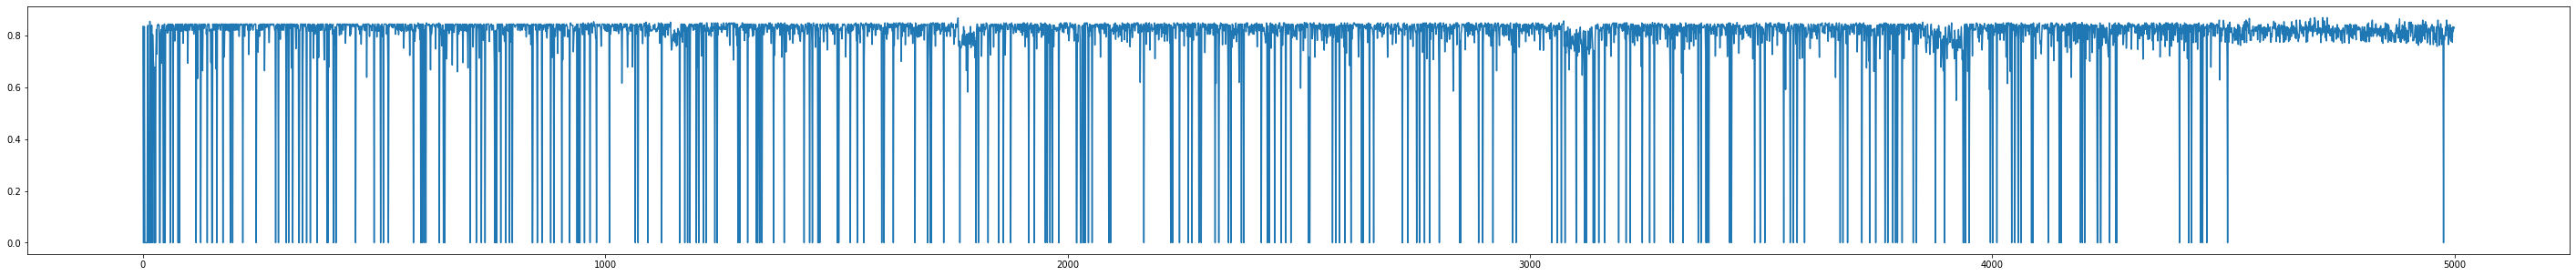

In [15]:
fig, axes = plt.subplots(1, 1, figsize = (50, 5))

axes.plot(np.array(score_arr))
plt.show()

In [ ]:
study.best_trial

FrozenTrial(number=258, values=[0.9152542372881356], datetime_start=datetime.datetime(2022, 7, 2, 17, 58, 25, 171513), datetime_complete=datetime.datetime(2022, 7, 2, 17, 58, 25, 219470), params={'penalty': 'l1', 'tol': 0.5149836846340519, 'C': 2.0790378268610903, 'fit_intercept': True, 'intercept_scaling': 9.976386859374466, 'solver': 'liblinear', 'random_state': 69}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'tol': UniformDistribution(high=10.0, low=0.0001), 'C': UniformDistribution(high=20.0, low=0.001), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'intercept_scaling': UniformDistribution(high=10.0, low=0.0001), 'solver': CategoricalDistribution(choices=('liblinear',)), 'random_state': IntUniformDistribution(high=100, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=258, state=TrialState.COMPLETE, value=None)

In [ ]:
study.best_params

{'C': 2.0790378268610903,
 'fit_intercept': True,
 'intercept_scaling': 9.976386859374466,
 'penalty': 'l1',
 'random_state': 69,
 'solver': 'liblinear',
 'tol': 0.5149836846340519}

In [16]:


clf = LogisticRegression(**study.best_params)

clf.fit(X_train, train['is_positive'])

LogisticRegression(C=4.027141868006357, intercept_scaling=3.452919234301036,
                   penalty='l1', random_state=31, solver='liblinear',
                   tol=0.1600828688704802)

In [ ]:
vec.vocabulary_

In [17]:
cross_val_score(clf, X_train, train['is_positive'], cv = 5, scoring='f1').mean()

0.8642396842796567

In [ ]:
test = pd.read_csv('responses_test.csv', index_col='id')

Применим построенный словарь мешка слов

In [ ]:
X_test = vec.transform(test['review'])

Применим полученную модель классификации.

In [ ]:
y_pred = clf.predict(X_test)

Соберем финальную таблицу. 


In [ ]:
test_submission = test.copy()
test_submission['is_positive'] = y_pred
test_submission = test_submission.drop(columns=['review'])
print(test_submission.shape)
test_submission.head()

(350, 1)


,is_positive
id,
795,True
848,True
1491,True
1228,True
93,False


Сохраним полученный файл

In [ ]:
test_submission.to_csv('test_submission.csv', index=True)